#  Recurrent Neural Networks (RNN)

Year: 2023-2024

Student 1: ### YASSINE KADDAMI ###

Student 2: ### HELIOTE ISMAEL ZAOULY ###

In this part, we will use a Recurrent Neural Networks (RNN) to fit multivariate time series and to make some predictions in the future. We will use the Lorenz-63 chaotic model, also known as the strange attractor (see https://en.wikipedia.org/wiki/Lorenz_system for more details).

First, we will generate and visualize trajectories from the Lorenz-63 system. From these data, we will build training and test datasets. Then, we will adjust two models to fit the data: a classic linear autoregressive model and the specific LSTM (Long Short-Term Memory) architecture of RNN. Finally, we will compare these models in terms of prediction and simulation of new trajectories.

In [1]:
# Import libraries
%pylab inline
%matplotlib inline

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Parameters (figure size)
pylab.rcParams['figure.figsize'] = (16, 9)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Declare the GPU (its name is "device")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Generate data**

Below, we define the 3-dimensional Lorenz-63 model given by:
\begin{aligned}{\frac {\mathrm {d} x_1}{\mathrm {d} t}}&=\sigma (x_2-x_1),\\[6pt]{\frac {\mathrm {d} x_2}{\mathrm {d} t}}&=x_1(\rho -x_3)-x_2,\\[6pt]{\frac {\mathrm {d} x_3}{\mathrm {d} t}}&=x_1 x_2-\beta x_3.\end{aligned}

This ordinary differential equation is using 3 physical parameters and we fix them to $\sigma=10$, $\rho=28$ and $\beta=8/3$. Then, we use Runge-Kutta 4-5 to integrate the model, using the *odeint()* Python function. The integration time is $0.01$ and we generate a sequence of $100$ Lorenz times.

In [11]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [12]:
from scipy.integrate import odeint

# Define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# Generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma,rho,beta))  
time = arange(0.01,T,dt)

# Transform array to tensor
x = torch.from_numpy(x).float()

**Visualize data**

They are 2 ways of visualizing the Lorenz-63 system. The first is to consider the system as a 3-dimensional time series: we plot each variable as a function of time. The second is the phase-space representation where we plot the relationships between variables in 3D and we track the trajectory along time.

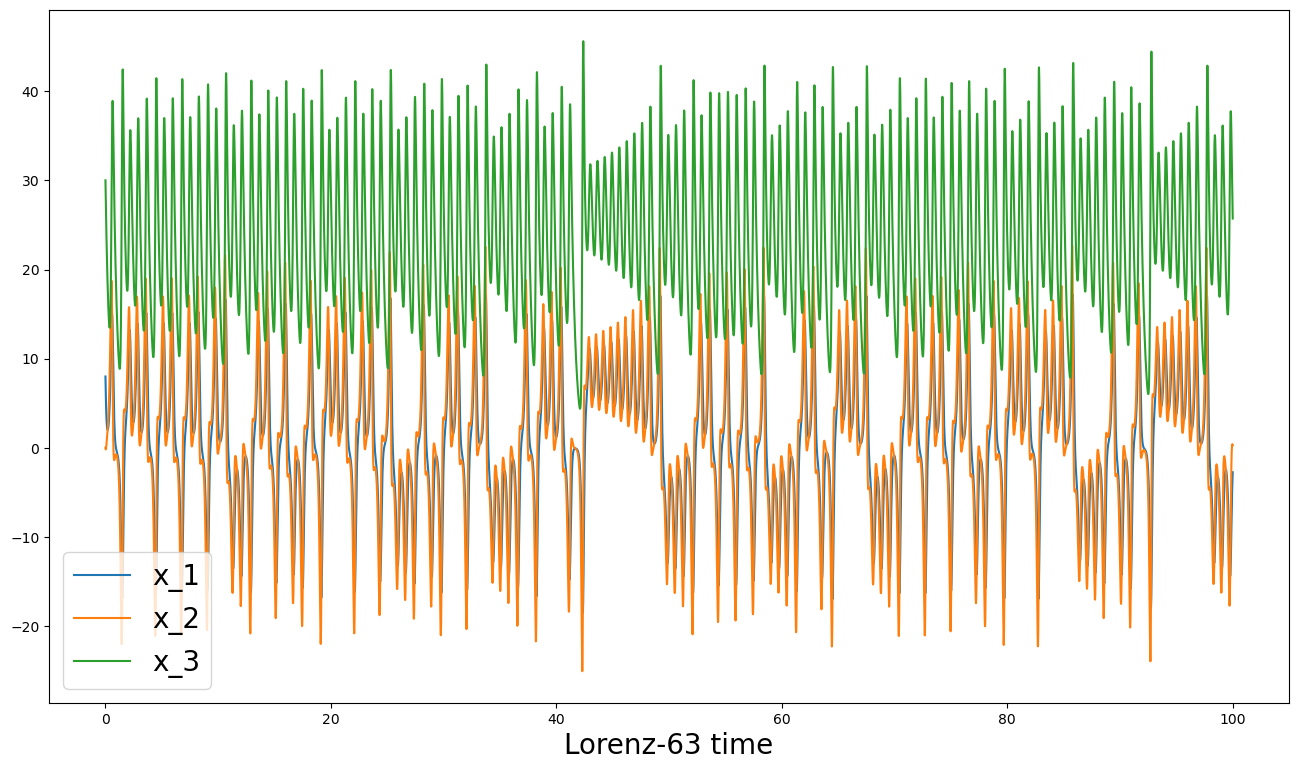

In [13]:
# Time series representation
plot(time, x)
xlabel('Lorenz-63 time', size=20)
legend(['x_1','x_2','x_3'], fontsize=20)

In [14]:
# Phase-space representation
from mpl_toolkits.mplot3d import Axes3D
fig = figure()
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2], 'k')
ax.set_xlabel('$x_1$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)

Text(0.5, 0, '$x_3$')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f96f61ef2e0> (for post_execute):


/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

<Figure size 1600x900 with 1 Axes>

**Create the training and test datasets**

Here, we want to predict the Lorenz-63 system at time t using the previous information at time t-0.01. It is thus a regression between the process and himself with a time delay. Here, we create a training (the first 2/3 of time series) and a test dataset (the last part).

In [15]:
# Size of the training set
T_train = int(T/dt*2/3)

# Training set
x_train = x[0:T_train,:]
y_train = x[1:T_train+1,:]

# Validation set
x_test = x[T_train+1:-1,]
y_test = x[T_train+2:,]

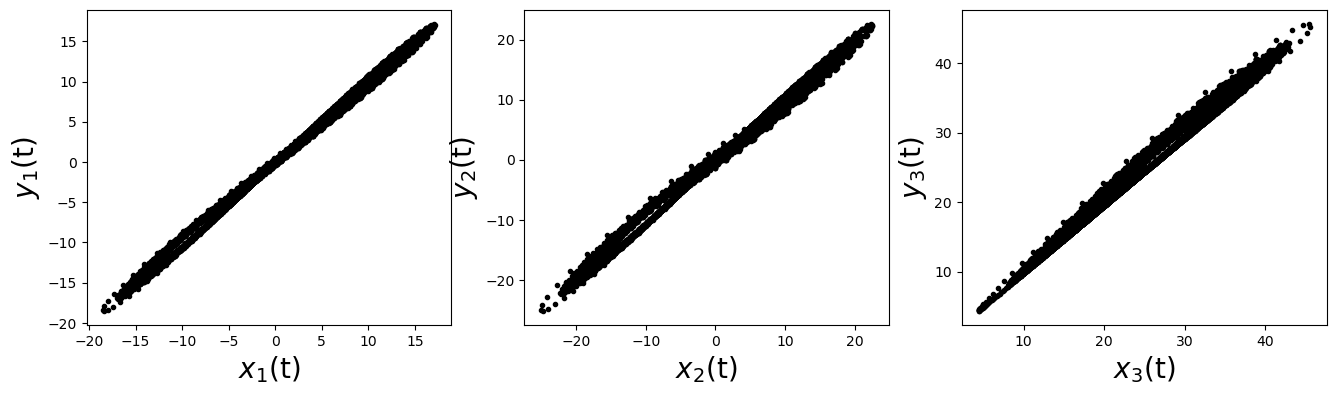

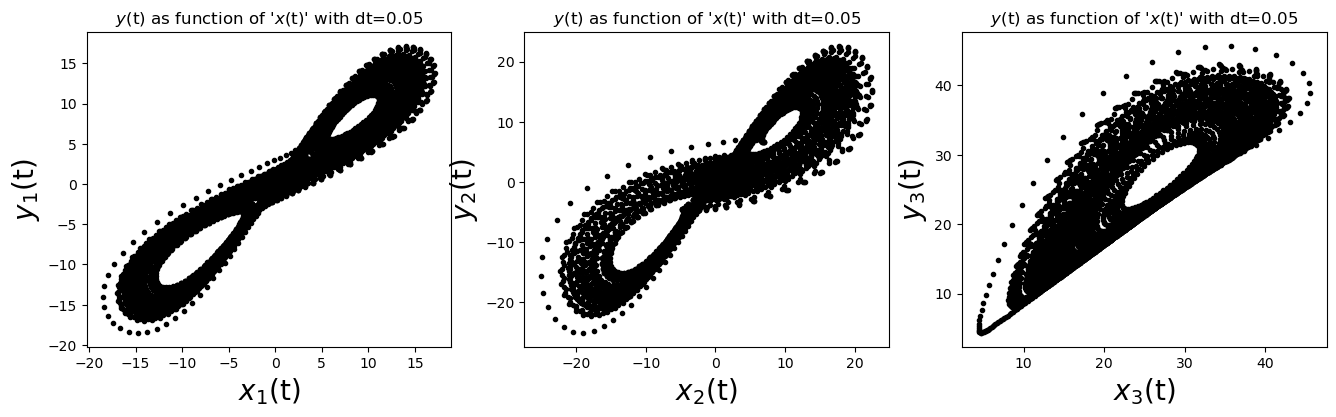

In [115]:

figure()
title("y_train as function of x_train with dt=0.01")
for i in range(3):
  subplot(2,3,i+1)
  plot(x_train[:,i],y_train[:,i],'.k')
  xlabel('$x_{}$(t)'.format(i+1),size=20)
  ylabel('$y_{}$(t)'.format(i+1),size=20)


figure()
for i in range(3):
  subplot(2,3,3+i+1)
  plot(x_train[0:-5,i],y_train[5:,i],'.k')
  xlabel('$x_{}$(t)'.format(i+1),size=20)
  ylabel('$y_{}$(t)'.format(i+1),size=20)
  title("$y_{}$(t) as function of '$x_{}$(t)' with dt=0.05")



We can see that with dt=0.01 we can model y_train as a linear function of 

When we indrease dt, we can see that the relationship between y-train and x_train has a form of a cycle. We can see that there os the butterfly effect : if we do a slight change in x_train , y_train will have a different behavior in time.

In [37]:
# Declare a class for linear regression
class model_AR1(nn.Module):
    
    # class initialization
    def __init__(self, input_size):
        super(model_AR1, self).__init__()
        # fully connected layer with linear activation
        self.fc = nn.Linear(input_size, input_size)
        
    # function to apply the neural network
    def forward(self, x):
        y_pred = self.fc(x)
        return y_pred

# Create the neural network (1 input size for x and 1 output size for y, bias is declared by default)
linear_model_AR1 = model_AR1(3)

# Print the model architecture
print(linear_model_AR1)

# Print the model parameters (weights of the neural network)
slope, bias = linear_model_AR1.parameters()
print('Slope: ', slope)
print('Bias: ', bias)

# Loss function: MSE = sum [(y - y_pred)^2], with y_pred = w0 + w1*x
criterion = nn.MSELoss()

# Optimizer: new_parameters = old_parameters - lr*gradient, with lr the learning rate
optimizer = torch.optim.SGD(linear_model_AR1.parameters(), lr = 0.001)


    
    

model_AR1(
  (fc): Linear(in_features=3, out_features=3, bias=True)
)
Slope:  Parameter containing:
tensor([[ 0.1978, -0.1805,  0.0325],
        [ 0.5699, -0.0338, -0.4238],
        [-0.1603, -0.4315,  0.2042]], requires_grad=True)
Bias:  Parameter containing:
tensor([ 0.4705, -0.4724, -0.1256], requires_grad=True)


In [117]:
epochs = 1000 # number of epochs
losses = [] # list to stock the loss at each iteration

# Loop on epochs
for i in range(epochs):
    
    # compute the prediction using the previous parameters of the neural networhnique. A classic procedure is the Stochastic Gradient Descent (SQG). Other optimizers are coded in PyTorch: https://pytorch.org/docs/stable/optim.html#.k
    y_pred = linear_model_AR1.forward(x_train)
    
    # compute and stock the loss
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
    
    # initialize the gradient to zero
    optimizer.zero_grad()
    
    # compute the gradient by back propagation
    loss.backward()
    
    # update the parameter values using the gradient
    optimizer.step()



In [118]:
slope, bias = linear_model_AR1.parameters()
print('Slope: ', slope)
print('Bias: ', bias)

Slope:  Parameter containing:
tensor([[ 0.8988,  0.0996, -0.0160],
        [-0.1250,  1.0922,  0.0165],
        [-0.0017,  0.0031,  1.0025]], requires_grad=True)
Bias:  Parameter containing:
tensor([ 0.4293, -0.4143, -0.0793], requires_grad=True)


The slope is close to the identity matrix.

First, we have to rearange the dataset used to train the RNN. We also store the dataset on the GPU.

In [41]:
# Reshape train and test data (with batch_size = 1)
x_train_LSTM = reshape(x_train, (shape(x_train)[0], 1, shape(x_train)[1]))
x_test_LSTM = reshape(x_test, (shape(x_test)[0], 1, shape(x_test)[1]))
y_train_LSTM = reshape(y_train, (shape(y_train)[0], 1, shape(y_train)[1]))
y_test_LSTM = reshape(y_test, (shape(y_test)[0], 1, shape(y_test)[1]))

# Store the data on the GPU
x_train_LSTM, x_test_LSTM = x_train_LSTM.to(device), x_test_LSTM.to(device)
y_train_LSTM, y_test_LSTM = y_train_LSTM.to(device), y_test_LSTM.to(device)

Then, we suggest to use the following RNN architecture with one LSTM layer and a fully connected layer with linear activation.

In [119]:
# Declare a class for LSTM
class LSTM_nn(nn.Module):
    # class initialization
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_nn, self).__init__()
        # LSTM layer with 1 hidden layer (hidden_size neurons inside)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = 1)
        # fully connected layer with linear activation
        self.fc = nn.Linear(hidden_size, output_size)

    # function to apply the neural network
    def forward(self, x):
        out, (h_out, c_out) = self.lstm(x)
        y_pred = self.fc(out)
        return y_pred, h_out, c_out

    # function to apply the neural network (when knowing the hidden state)
    def forward_using_last_hidden_layer(self, x, h, c):
        out, (h_out, c_out) = self.lstm(x, (h, c))
        y_pred = self.fc(out)
        return y_pred, h_out, c_out

In the next cell, we initialize a LSTM with 10 neurons in the hidden layer. Here, we transfer the LSTM model to the GPU.

In [43]:
# Create the LSTM (3 input size for x and 3 output size for y, 10 neurons in the hidden layer)
model_RNN = LSTM_nn(3, 10, 3)

# Use the GPU to train the model
model_RNN.to(device)

LSTM_nn(
  (lstm): LSTM(3, 10)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)

Then, you will have to optimize the LSTM. We suggest to carrefully check the loss function along the epochs. The number of epoch needed to converge can be large, depending on the optimizer and the learning rate.

In [53]:
# Loss function: MSE = sum [(y - y_pred)^2], with y_pred = w0 + w1*x
criterion = nn.MSELoss()

# Optimizer: new_parameters = old_parameters - lr*gradient, with lr the learning rate
optimizer = torch.optim.Adam(model_RNN.parameters(), lr = 0.01)

epochs = 5000# number of epochs
losses = [] # list to stock the loss at each iteration

# Loop on epochs
for i in range(epochs):
    
    # compute the prediction using the previous parameters of the neural networhnique. A classic procedure is the Stochastic Gradient Descent (SQG). Other optimizers are coded in PyTorch: https://pytorch.org/docs/stable/optim.html#.k
    y_pred,_,_ = model_RNN.forward(x_train_LSTM)
    
    # compute and stock the loss
    loss = criterion(y_pred, y_train_LSTM)
    
    # initialize the gradient to zero
    optimizer.zero_grad()
    
    # compute the gradient by back propagation
    loss.backward()
    
    # update the parameter values using the gradient
    optimizer.step()

    if i % 100 == 0:
        print(f"Epochs: {i} , MSE: {loss.item()}")

    losses.append(loss.item())


Epochs: 0 , MSE: 3.5409579277038574
Epochs: 100 , MSE: 0.6613845229148865
Epochs: 200 , MSE: 0.16373227536678314
Epochs: 300 , MSE: 0.06526648998260498
Epochs: 400 , MSE: 0.03365865722298622
Epochs: 500 , MSE: 0.020058175548911095
Epochs: 600 , MSE: 0.013097596354782581
Epochs: 700 , MSE: 0.014629214070737362
Epochs: 800 , MSE: 0.008355741389095783
Epochs: 900 , MSE: 0.0149121955037117
Epochs: 1000 , MSE: 0.01016229297965765
Epochs: 1100 , MSE: 0.005314914509654045
Epochs: 1200 , MSE: 0.005779649596661329
Epochs: 1300 , MSE: 0.005039357580244541
Epochs: 1400 , MSE: 0.0199841670691967
Epochs: 1500 , MSE: 0.0036058227997273207
Epochs: 1600 , MSE: 0.004758690483868122
Epochs: 1700 , MSE: 0.0030240844935178757
Epochs: 1800 , MSE: 0.0029635708779096603
Epochs: 1900 , MSE: 0.002656788332387805
Epochs: 2000 , MSE: 0.0027962173335254192
Epochs: 2100 , MSE: 0.003050345228984952
Epochs: 2200 , MSE: 0.002633881289511919
Epochs: 2300 , MSE: 0.028675425797700882
Epochs: 2400 , MSE: 0.00197274819947

NameError: name 'n_epochs' is not defined

Text(0, 0.5, 'loss value')

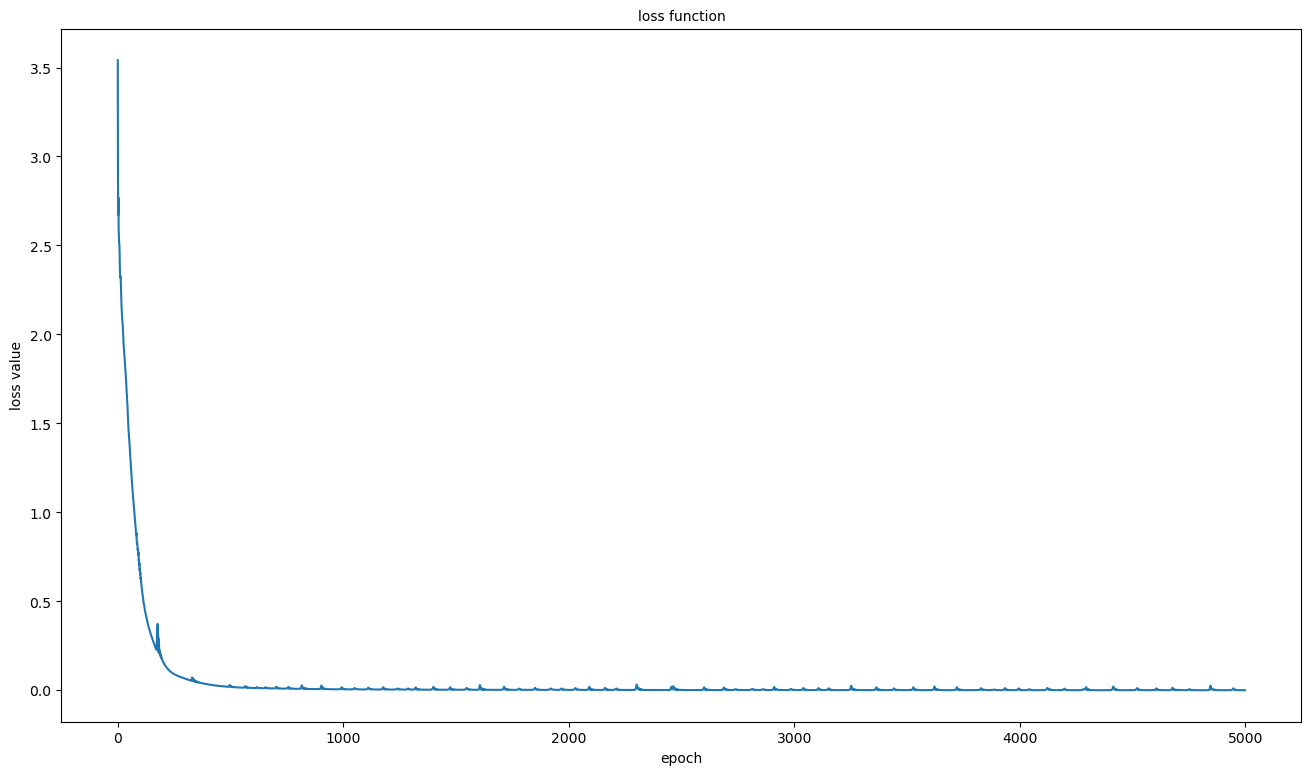

In [54]:
plt.plot(range(epochs), losses)
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

First, you have to transfer the prediction of your LSTM from the GPU.

In [55]:
# Make predictions from the AR1 and LSTM models
y_AR1_hat = linear_model_AR1.forward(x_test)
y_RNN_hat, h_hat, c_hat = model_RNN.forward(x_test_LSTM)

# Transfer data from the GPU
y_RNN_hat = y_RNN_hat.cpu()

In [61]:
loss_AR1 = torch.sqrt(criterion(y_AR1_hat, y_test))
loss_RNN = torch.sqrt(criterion(y_RNN_hat[:,0,:], y_test))

print(f"The RMSE for AR1 is :{loss_AR1}")
print(f"The RMSE for RNN is :{loss_RNN}")

The MSE for AR1 is :0.5490541458129883
The MSE for RNN is :0.05940082296729088


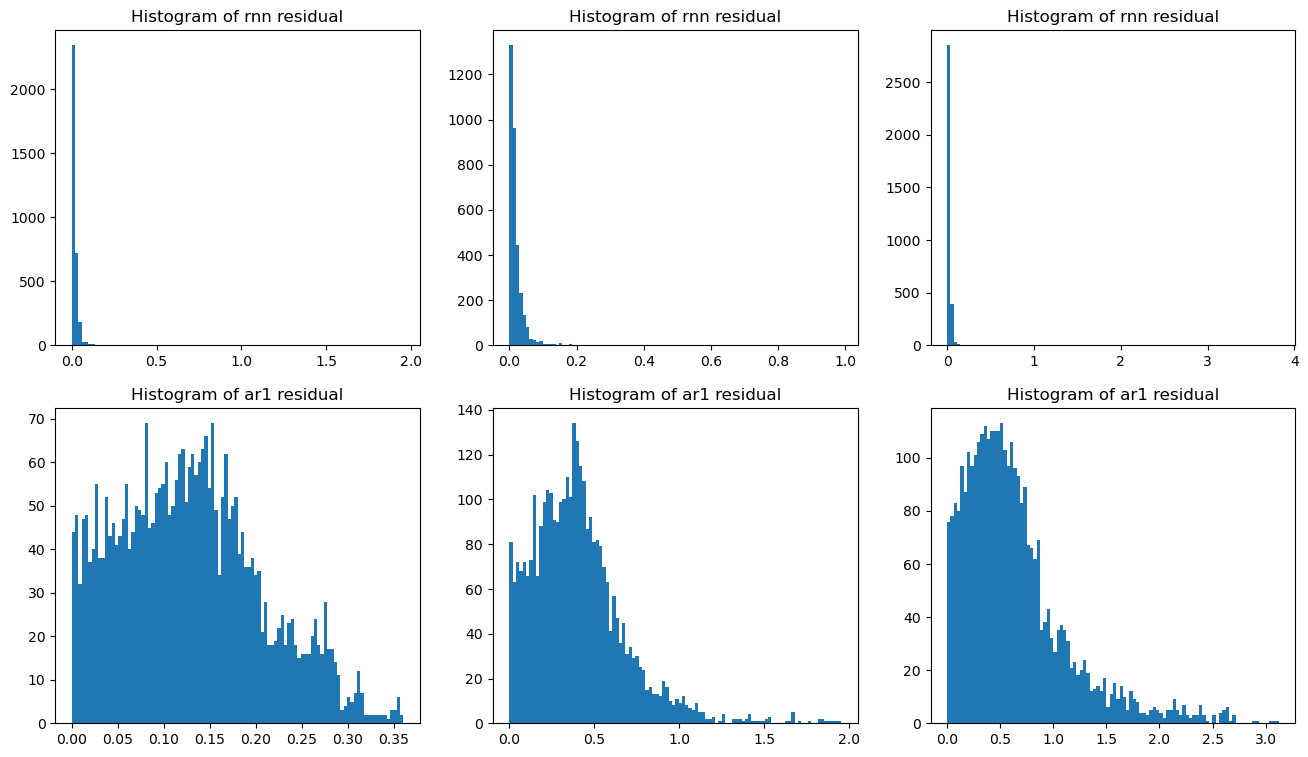

In [126]:
for i in range(3):
    subplot(2,3,i+1)
    rnn_residual = abs(y_RNN_hat[:,0,i] - y_test[:,i])
    plt.hist(rnn_residual.detach().numpy(), bins=100) 
    plt.title("Histogram of rnn residual")
    
    subplot(2,3,3+i+1)
    ar1_residual = abs(y_AR1_hat[:,i] - y_test[:,i])
    plt.hist(ar1_residual.detach().numpy(), bins=100) 
    plt.title("Histogram of ar1 residual")



The rnn_model is better than the AR1 according to the histogram.

In [95]:
len_simu = 1500 # length of the simulation
x0_AR1 = y_test[-1,:] # initial condition for AR(1)
x0_LSTM = y_test_LSTM[-100:,:,:] # initial condition for LSTM (needed to learn the neurons in the hidden layer)

# Initialize resulting arrays
x_AR1 = torch.zeros((len_simu,3))
x_RNN = torch.zeros((len_simu,3)).to(device)
x_AR1[0,:] = x0_AR1
x_RNN[0,:] = x0_LSTM[-1,:]

# Estimate h and c of the LSTM using several Lorenz times
x_RNN_tmp, h_hat, c_hat = model_RNN.forward(x0_LSTM)

# Loop on the previous prediction
for i in range(len_simu-1): 
  x_AR1[i+1,:] =  linear_model_AR1.forward(x_AR1[i,:])
  x_RNN_tmp, h_hat, c_hat = model_RNN.forward_using_last_hidden_layer(x_RNN_tmp,h_hat, c_hat)
  x_RNN[i+1,:] = x_RNN_tmp[-1,:]

# Generate the true run
x_truth = odeint(Lorenz_63, y_test[-1,:], arange(0.01,(len_simu+1)*dt,dt), args=(sigma,rho,beta))

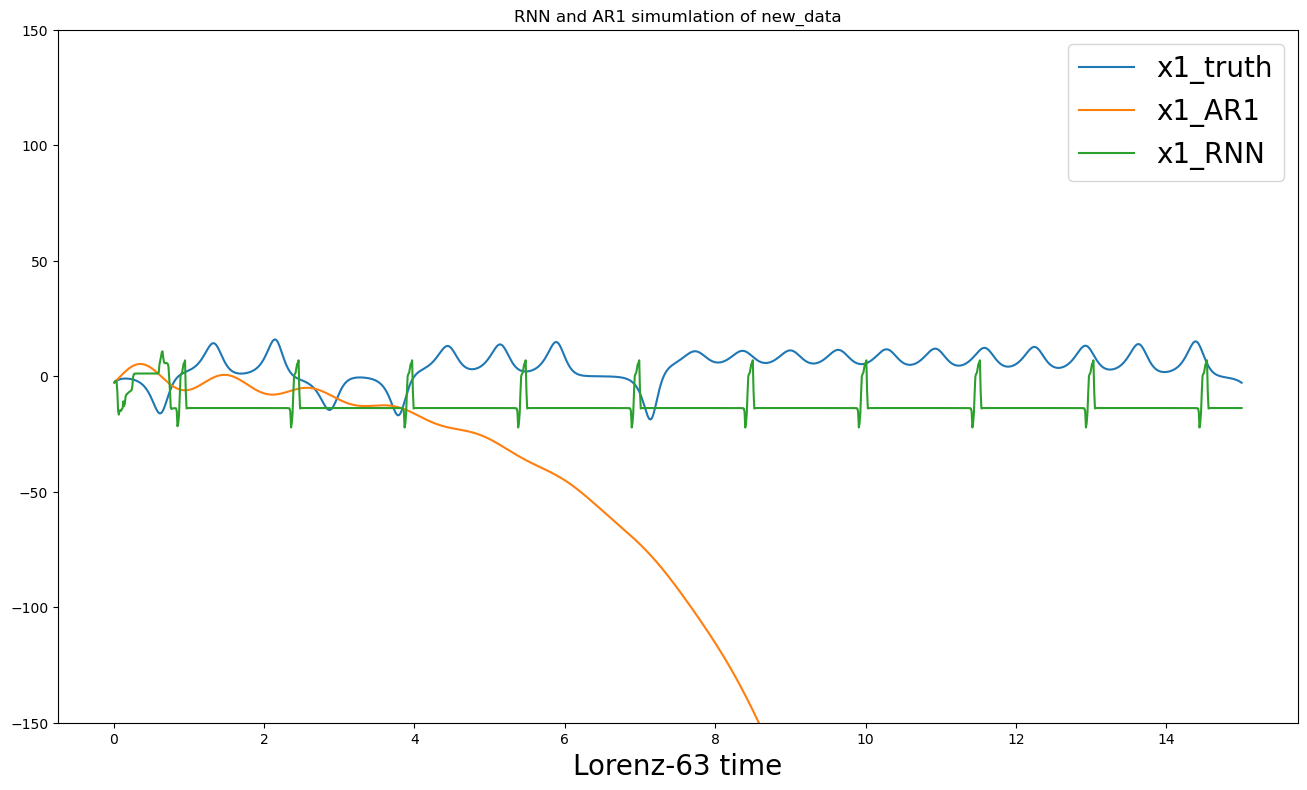

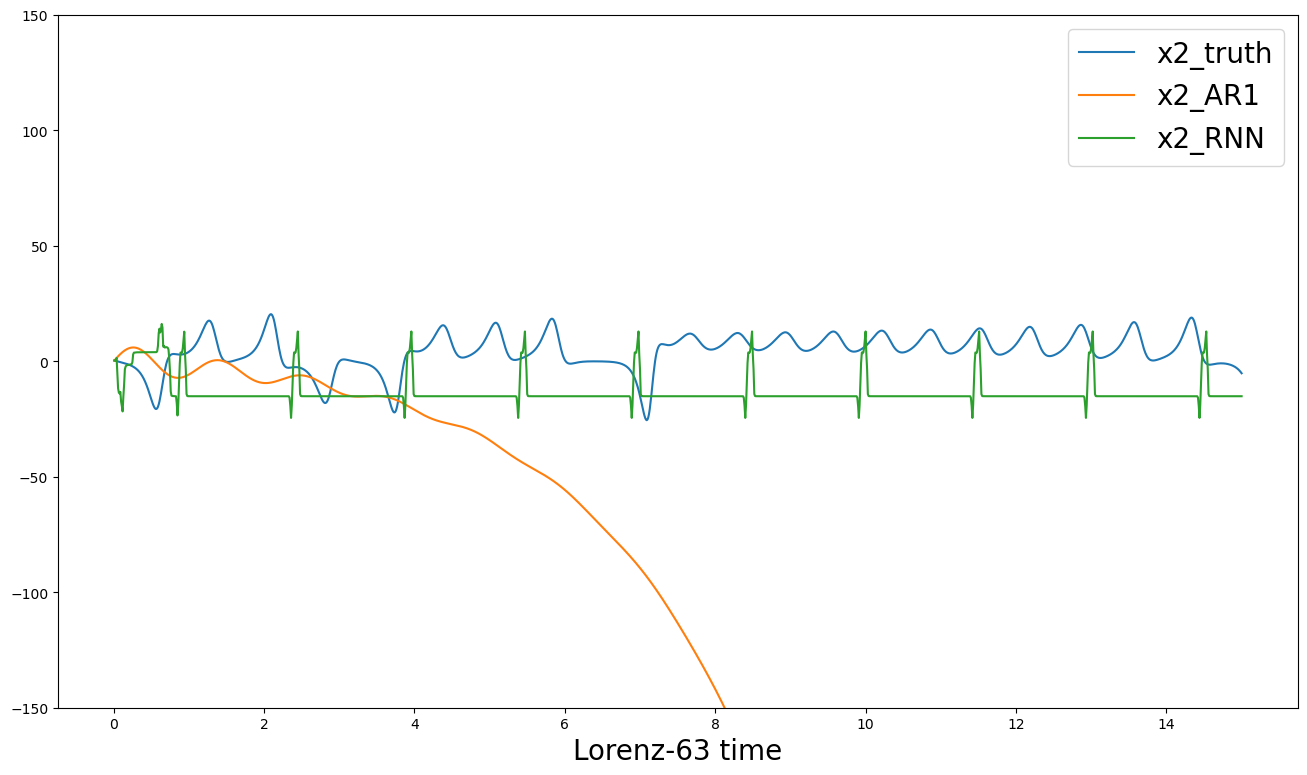

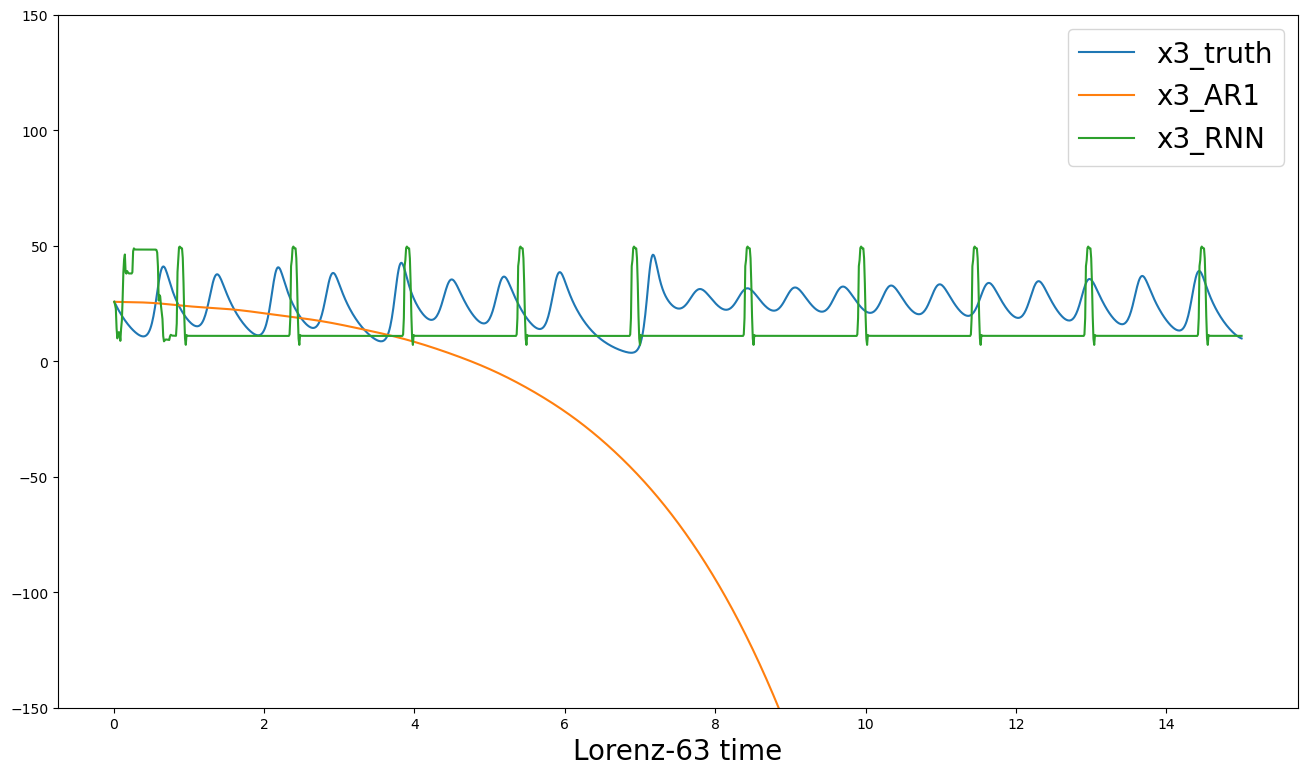

In [137]:
# Time series representation
time = arange(0.01,(len_simu+1)*dt,dt)


fig, ax = plt.subplots()
ax.plot(time, x_truth[:,0])
ax.plot(time, x_AR1[:,0].detach().numpy())
ax.plot(time, x_RNN[:,0].cpu().detach().numpy())


xlabel('Lorenz-63 time', size=20)
ax.set_ylim(-150, 150)
legend(['x1_truth','x1_AR1','x1_RNN'], fontsize=20)
title("RNN and AR1 simumlation of new_data")


fig, ax = plt.subplots()
ax.plot(time, x_truth[:,1])
ax.plot(time, x_AR1[:,1].detach().numpy())
ax.plot(time, x_RNN[:,1].cpu().detach().numpy())


xlabel('Lorenz-63 time', size=20)
ax.set_ylim(-150, 150)
legend(['x2_truth','x2_AR1','x2_RNN'], fontsize=20)

fig, ax = plt.subplots()
ax.plot(time, x_truth[:,2])
ax.plot(time, x_AR1[:,2].detach().numpy())
ax.plot(time, x_RNN[:,2].cpu().detach().numpy())


xlabel('Lorenz-63 time', size=20)
ax.set_ylim(-150, 150)
legend(['x3_truth','x3_AR1','x3_RNN'], fontsize=20)




**Response:**
The resulting trajectories don't look the same as the original especially for the AR1. However we can see that the RNN prediction are closer to the reality.


We want to propose and implement a new model to increase the quality of the prediction. We suggest to transform the input and take into account more time lags (i.e., $t-1$, $t-2$, $t-3$) to explain the Lorenz-63 system at time $t$. This can be done using a linear regression and in that case, we are talking about a AR(3) model.

In [147]:
# Declare a class for linear regression
class model_AR3(nn.Module):
    
    # class initialization
    def __init__(self, input_size, output_size):
        super(model_AR3, self).__init__()
        # fully connected layer with linear activation
        self.fc = nn.Linear(input_size, output_size)
        
    # function to apply the neural network
    def forward(self, x):
        y_pred = self.fc(x)
        return y_pred

# Create the neural network (1 input size for x and 1 output size for y, bias is declared by default)
linear_model_AR3 = model_AR3(9, 3)

# Print the model architecture
print(linear_model_AR3)

# Print the model parameters (weights of the neural network)
slope, bias = linear_model_AR3.parameters()
print('Slope: ', slope)
print('Bias: ', bias)

# Loss function: MSE = sum [(y - y_pred)^2], with y_pred = w0 + w1*x
criterion = nn.MSELoss()

# Optimizer: new_parameters = old_parameters - lr*gradient, with lr the learning rate
optimizer = torch.optim.SGD(linear_model_AR3.parameters(), lr = 0.001)

model_AR3(
  (fc): Linear(in_features=9, out_features=3, bias=True)
)
Slope:  Parameter containing:
tensor([[ 0.0160,  0.2797,  0.1758,  0.0065, -0.0767, -0.3087,  0.1882,  0.0026,
          0.1959],
        [ 0.1255,  0.2575, -0.1857,  0.2982,  0.0009, -0.0985,  0.2241, -0.1715,
         -0.2139],
        [-0.0520, -0.2154, -0.3033, -0.1093, -0.1090,  0.0795,  0.3245, -0.2339,
          0.0239]], requires_grad=True)
Bias:  Parameter containing:
tensor([-0.1072, -0.0100,  0.2698], requires_grad=True)


In [151]:
epochs = 1000 # number of epochs
losses = [] # list to stock the loss at each iteration

# Training set
x2_train = x[2:T_train+2,:]
x1_train = x[1:T_train+1,:]
x0_train = x[0:T_train,:]
x_train = torch.cat((x0_train,x1_train,x2_train), dim=1)
y_train = x[1:T_train+1,:]
print(x_train.shape)

# Loop on epochs
for i in range(epochs):
    
    # compute the prediction using the previous parameters of the neural networhnique. A classic procedure is the Stochastic Gradient Descent (SQG). Other optimizers are coded in PyTorch: https://pytorch.org/docs/stable/optim.html#.k
    y_pred = linear_model_AR3.forward(x_train)
    
    # compute and stock the loss
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
    
    # initialize the gradient to zero
    optimizer.zero_grad()
    
    # compute the gradient by back propagation
    loss.backward()
    
    # update the parameter values using the gradient
    optimizer.step()
loss.item()

torch.Size([6666, 9])


0.00866712536662817

In [163]:
x2_test = x[T_train+3:-1,]
x1_test = x[T_train+2:-2,]
x0_test = x[T_train+1:-3,]
x_test_AR3 = torch.cat((x0_test,x1_test,x2_test), dim=1)

In [166]:
# Make predictions from the AR1 and LSTM models
y_AR1_hat = linear_model_AR1.forward(x_test)
y_AR3_hat = linear_model_AR3.forward(x_test_AR3)
y_RNN_hat, h_hat, c_hat = model_RNN.forward(x_test_LSTM)

# Transfer data from the GPU
y_RNN_hat = y_RNN_hat.cpu()
loss_AR1 = torch.sqrt(criterion(y_AR1_hat, y_test))
loss_RNN = torch.sqrt(criterion(y_RNN_hat[:,0,:], y_test))
loss_AR3 = torch.sqrt(criterion(y_AR3_hat, y_test[:-1e of tensor a (6666) must match the size of tensor b (6665) at non-sing,:]))

print(f"The RMSE for AR1 is :{loss_AR1}")
print(f"The RMSE for RNN is :{loss_RNN}")
print(f"The RMSE for AR3 is :{loss_AR3}")

The RMSE for AR1 is :0.5490541458129883
The RMSE for RNN is :0.05940082296729088
The RMSE for AR3 is :0.6537618041038513
